In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import scipy as sp
import pickle 
import random
from scipy import optimize as opt
from astropy.io import fits
from astropy.table import Table, Column, vstack, hstack
import pyarrow.parquet as pq
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde


# ---------------------------------------------
## functions

def calc_cuts(colors_good, colors_bad):
    
    """
    Inputs: 
    colors_good = z-mag, and z-w1 of sources that have sigma_z/1+z < threshold value; 
                  a list of two arrays
    colors_bad  = z-mag, and z-w1 of sources that have sigma_z/1+z > threshold value; 
                  a list of two arrays
    
    -----------
    What does it do? 
    
    - In short, it uses a logistic regression model to calculate boundaries between the two populations
    
    - Specifically, given input parameters, z-mag and z-w1 color, a logistic function is used to 
      to map from these parameters to probability (0, 1] of a data point belonging to a particular class.
      
       - Inputs are linearly combined into z = w1*x1 + w2*x2 + b where x1, x2 are inputs and w1, w2 are the 
         weights learned by the model, and b is the bias term. 
         
       - Then z is passed through the sigmoid (logistic) function to convert it into a probability 
         P(y=1 | x) = sigma(z) \propto 1 / (1 + exp(x)). 
         
       - The weights are learned and optimized by going along the direction of the fastest loss gradient
         (slope change), until it reaches a minimum loss. 
        
       - Finally, using these optimized weights, it assigns probability of data points that belong to the 
         "bad" class. 
    
    - Eventually, the various contour levels represent the probability of sources belonging to the bad class.
    
    For more details, see section 3: Calculate Decision Boundaries
    
    """
    
    # parse "good" and "bad" populaitons on the color-magnitude space
    (cl_x_good, cl_y_good) = colors_good
    (cl_x_bad, cl_y_bad) = colors_bad
    
    # keep only finite values
    good_mask = np.isfinite(cl_x_good) & np.isfinite(cl_y_good)
    bad_mask = np.isfinite(cl_x_bad) & np.isfinite(cl_y_bad)
    
    # Combine good and bad populations into a single dataset
    X_good = np.vstack((cl_x_good[good_mask], cl_y_good[good_mask])).T
    X_bad = np.vstack((cl_x_bad[bad_mask], cl_y_bad[bad_mask])).T
    X = np.vstack((X_good, X_bad))
    y = np.hstack((np.zeros(X_good.shape[0]), np.ones(X_bad.shape[0])))  # 0: good, 1: bad

    # split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # standardize the data for betater performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # train a Logistic Regression classifier
    clf = LogisticRegression()
    clf.fit(X_train_scaled, y_train)

    # generate probability contours instead of hard decision boundaries
    # create a mesh grid to plot decision boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    
    # predict probabilities on the mesh grid
    probs = clf.predict_proba(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))[:, 1].reshape(xx.shape)  

    return xx, yy, probs

### redshift cuts
def redshift_cuts(est_sigz, bin_want, tab_photz_zerr=None):
    """
    est_sigz = estimated sigma_z / (1+z)
    bin_want = which redshift accuracy bin, start from index 0 to 5,
               (index 5 is the non-science sample, sigma_z/1+z > 0.2)
    
    Returns:
    a boolean array
    """
    cuts = [(est_sigz < 0.003), 
            (est_sigz < 0.01) & (est_sigz > 0.003),
            (est_sigz < 0.03) & (est_sigz > 0.01), 
            (est_sigz < 0.1) & (est_sigz > 0.03), 
            (est_sigz < 0.2) & (est_sigz > 0.1),
            (est_sigz > 0.2)] 
    cut_want = cuts[bin_want]

    return cut_want

def redshift_cuts_cum(est_sigz, bin_want, tab_photz_zerr=None):
    """
    Cumulative redshift bins
    est_sigz = estimated sigma_z / (1+z)
    bin_want = which redshift accuracy bin, start from index 0 to 4
    
    Returns:
    boolean array
    """
    cuts = [(est_sigz < 0.003),
            (est_sigz < 0.01),
            (est_sigz < 0.03),
            (est_sigz < 0.1),
            (est_sigz < 0.2),
            (est_sigz > 0.2)]
    
    cut_want = cuts[bin_want]
    return cut_want


def Gaussian(x, A, sig, x0):
    return A * np.exp(-(x-x0)**2 / (2*sig**2))

def flux_to_mag(flux_Jy):
    """
    flux_Jy in Jy
    """
    m = -2.5 * np.log10(flux_Jy / 3631)
    return m

def boundary_LS(x, a, b):
    ### function to fit boundaries
    f = a*x+b
    return f

def calc_fit_contour(contours):
    
    ## function to fit a given contour line
    for ii, collection in enumerate(contours.collections):
        paths = collection.get_paths()
        for path in paths:
            vertices = path.vertices
            x_values = vertices[:, 0]
            y_values = vertices[:, 1]
    
    (fit, err) = opt.curve_fit(boundary_LS, x_values, y_values, absolute_sigma=True)
    return fit

def calc_source_separation(RA, DEC):
    """
    RA, DEC = numpy arrays of ra, dec
    
    calculates the distance to nearest neighbors for given sources
    
    """
    nearest_distances = []
    coords = SkyCoord(ra=RA * u.deg, dec=DEC * u.deg, frame='icrs')

    # calculate the angular separation to find nearest neighbors
    for ii, coord in enumerate(coords):
        separations = coord.separation(coords)
        separations[ii] = np.inf

        # find the minimum separation, which is the nearest neighbor
        nearest_distance = np.min(separations).to("arcsec").value
        nearest_distances.append(nearest_distance)

    nearest_distances = np.array(nearest_distances)
    
    return nearest_distances


# Load files

In [11]:
### load in files

# cross matched catalog between COSMOS166k and refcat v0.6 --> 110k sources
# please directly reach out to me (Gemma Huai) if you have questions about the cross-matched catalog.
# It combines a couple columns from the spherex refcat v0.6 (up until 'nobs_w2') and 'Tractor_ID' & 
# 'redshift' from the COSMOS catalog, with photo-z output (from 'z_best' to the end) table after running
# QuickCatalog (no Tractor) on each individual source with sky-averaged zodi light. 

tab_xmatch = Table.read("./COSMOS2020_SPHEXrefcat_v0.6_110k_SkyAvgZodi_gemma_OCT2024.csv")
print(tab_xmatch.colnames)


['SPHERExRefID', 'LegacySurvey_uid', 'ra', 'dec', 'ra_error', 'dec_error', 'Gaia_G', 'LS_g', 'LS_r', 'LS_z', 'LS_g_error', 'LS_r_error', 'LS_z_error', 'LS_type', 'flag_blending', 'flag_brightneighbor', 'dist_nearest', 'class', 'spherex_class', 'z', 'z_err', 'z_dup', 'z_survey', 'z_ID', 'LS_W1', 'LS_W2', 'LS_W1_err', 'LS_W2_err', 'fiberflux_g', 'fiberflux_r', 'fiberflux_z', 'fibertotflux_g', 'fibertotflux_r', 'fibertotflux_z', 'nobs_g', 'nobs_r', 'nobs_z', 'nobs_w1', 'nobs_w2', 'Tractor_ID', 'redshift', 'z_best', 'z_med', 'z_err_std', 'z_err_l68', 'z_err_u68', 'skewness', 'kurtosis', 'minchi2_minchi2', 'z_minchi2', 'loge_density_minchi2', 'mod_minchi2', 'extlaw_minchi2', 'ebv_minchi2', 'scale_minchi2', 'loge_pdfsum', 'z_pdfmax', 'loge_density_pdfmax', 'minchi2_pdfmax', 'mod_pdfmax', 'extlaw_pdfmax', 'ebv_pdfmax', 'scale_pdfmax', 'snr_per_filter']


# Color - magnitude plot

/var/folders/j1/knmv27vj4yvcyh0vlxr3f96h0000gn/T/ipykernel_37588/3346383610.py:147: RuntimeWarning: divide by zero encountered in log10
  m = -2.5 * np.log10(flux_Jy / 3631)
/var/folders/j1/knmv27vj4yvcyh0vlxr3f96h0000gn/T/ipykernel_37588/3346383610.py:147: RuntimeWarning: invalid value encountered in log10
  m = -2.5 * np.log10(flux_Jy / 3631)


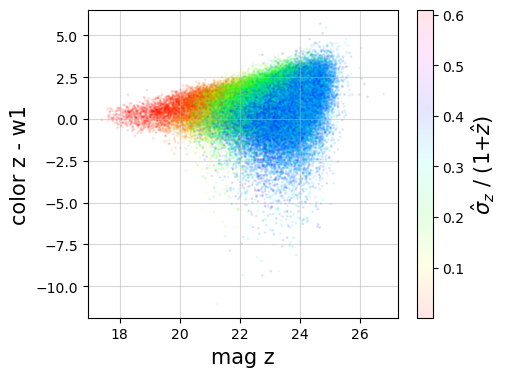

In [3]:
## Plot color-magnitude diagram, with redshift uncertainty

sphx_z_flux_uJy = tab_xmatch['LS_z'] # in uJy
sphx_w1_flux_uJy = tab_xmatch['LS_W1']

# calculate z and w1 magnitude 
sphx_z_mag = flux_to_mag(sphx_z_flux_uJy/1e6)
sphx_w1_mag = flux_to_mag(sphx_w1_flux_uJy/1e6)

# photoz outputs
z_err = tab_xmatch['z_err_std']
z_est = tab_xmatch['z_best']
sig_z = z_err / (1 + z_est) # estimated redshfit uncertainty

# plot x, and y 
cl_x = sphx_z_mag
cl_y = sphx_z_mag - sphx_w1_mag

# plot color - magnitude, color code by redshift uncertainty
plt.figure(figsize=(5, 4))
plt.scatter(cl_x, 
            cl_y, 
            c = (sig_z), 
            s=1, 
            alpha=0.1, cmap='hsv')

cbar = plt.colorbar()
cbar.set_label(r"$\hat{\sigma}_z$ / (1+$\hat{z}$)", fontsize=15)
plt.xlabel("mag z", fontsize=15)
plt.ylabel("color z - w1", fontsize=15)
plt.grid(alpha=0.5)

# Calculate decision boundaries:

__Using logistic regression model:__

What does it do? 

- In short, a logistic regression model is used to calculate boundaries between the two populations.

- Specifically, given input parameters, z-mag and z-w1 color, a logistic function is used to 
  to map from these parameters to probability (0, 1] of a data point belonging to a particular class.

   - Inputs are linearly combined into $z = w1*x1 + w2*x2 + b$ where $x1, x2$ are inputs and $w1, w2$ are the 
     weights learned by the model, and b is the bias term. 

   - Then z is passed through the sigmoid (logistic) function to convert it into a probability 
     $P(y=1 | x) = \sigma(z) \propto \frac{1}{1 + e^z}$. 
     
   - Loss function: used to measure the difference between the predicted probabilities and the actual class labels. For each data point, the loss is $\text{loss} = -(y \text{log}(P(y=1|x)) + (1-y)\text{log}(1-P(y=1|x))) $, where for y=1 the point is in the positive class; y=0 in the negative class. 
   
   - The total cost function is computed using the loss function , $J(w,b) = \frac{1}{m}\sum_{i=1}^m \text{loss}_i$ where m is the number of data points. 

   - The weights are learned and optimized by minimizing the loss function using the gradient. At each step, the gradient tells the model the direction in which the weights should move to decrease the loss. 

   - Finally, when the process converges, using these optimized weights, it assigns probability of data points that belong to the negative class.

- Eventually, the various contour levels represent the probability of sources belonging to the bad class.


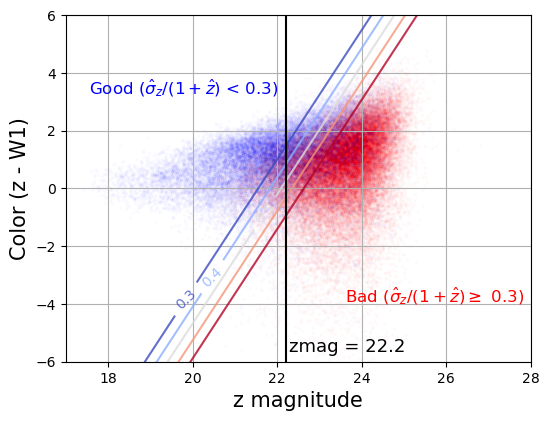

In [4]:
## calculate the decision boundaries

# choose a sigma_z/1+z cut, we want to be conservative here
cut = 0.3 

cut_good = (sig_z <= cut)
cut_bad = (sig_z > cut)

cl_x_good = sphx_z_mag[cut_good]
cl_y_good = sphx_z_mag[cut_good] - sphx_w1_mag[cut_good]
cl_x_bad = sphx_z_mag[cut_bad]
cl_y_bad = sphx_z_mag[cut_bad] - sphx_w1_mag[cut_bad]


# train the boundaries
(xx, yy, probs) = calc_cuts([cl_x_good,cl_y_good], [cl_x_bad, cl_y_bad])

# plot everything
plt.figure(figsize=(6, 4.5))

plt.scatter(cl_x_bad, cl_y_bad, color='red', alpha=0.01, s=3, label=r'Bad ($\hat{\sigma}_z/(1+\hat{z})$ >= 0.3)')
plt.scatter(cl_x_good, cl_y_good, color='blue', alpha=0.01, s=3, label=r'Good ($\hat{\sigma}_z/(1+\hat{z})$ < 0.3)')

# plot the decision boundary 
contour_levels = [0.3, 0.4, 0.5, 0.6, 0.7] # probability contours
contour = plt.contour(xx, yy, probs, levels=contour_levels, cmap="coolwarm", alpha=0.8)
plt.clabel(contour, inline=True, fontsize=10, fmt='%1.1f')

plt.axvline(22.2, color='black')
plt.text(0.48, 0.07, 'zmag = 22.2', transform=plt.gca().transAxes, fontsize=13, color='black', verticalalignment='top')

plt.xlim(17, 28)
plt.ylim(-6, 6)
plt.xlabel('z magnitude', fontsize=15)
plt.ylabel('Color (z - W1)', fontsize=15)
# plt.legend(loc='upper left', fontsize=13)
plt.text(0.05, 0.82, r'Good ($\hat{\sigma}_z/(1+\hat{z})$ < 0.3)', transform=plt.gca().transAxes, fontsize=12, color='blue', verticalalignment='top')
plt.text(0.6, 0.22, r'Bad ($\hat{\sigma}_z/(1+\hat{z})\geq$ 0.3)', transform=plt.gca().transAxes, fontsize=12, color='red', verticalalignment='top')

plt.grid(True)

plt.show()

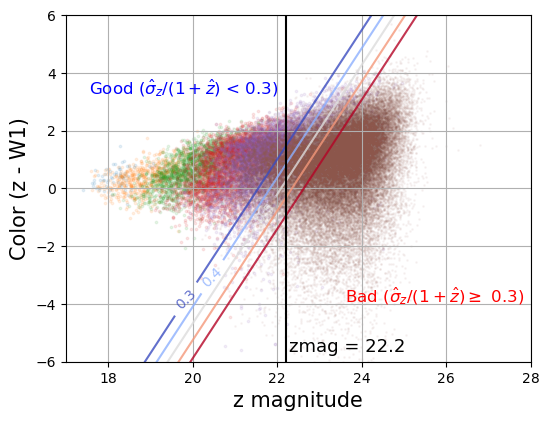

In [5]:
### plot the results and binned redshift accuracy

# calculate sources in each redshift bin
z_bins = []
for z in range(6):
    z_bins.append(redshift_cuts(sig_z, z)) # a stack of boolean arrays

# plot the results
plt.figure(figsize=(6, 4.5))

# our science sample (sigma_z/1+z < 0.2)
for j in range(5):
    plt.scatter(cl_x[z_bins[j]], cl_y[z_bins[j]], alpha=0.1, s=3, label=f'z bin {j}')

# our non-science sample (sigma_z/1+z > 0.2)
plt.scatter(cl_x[z_bins[5]], cl_y[z_bins[5]], alpha=0.05, s=1)

# plot the decision boundaries
contour_levels = [0.3, 0.4, 0.5, 0.6, 0.7]
contour = plt.contour(xx, yy, probs, levels=contour_levels, cmap="coolwarm", alpha=0.8)
plt.clabel(contour, inline=True, fontsize=10, fmt='%1.1f') 

plt.axvline(22.2, color='black')
plt.text(0.48, 0.07, 'zmag = 22.2', transform=plt.gca().transAxes, fontsize=13, color='black', verticalalignment='top')

plt.xlim(17, 28)
plt.ylim(-6, 6)
plt.xlabel('z magnitude', fontsize=15)
plt.ylabel('Color (z - W1)', fontsize=15)
# plt.legend(loc='upper right', fontsize=13)
plt.text(0.05, 0.82, f'Good ($\hat{{\sigma}}_z/(1+\hat{{z}})$ < {cut})', transform=plt.gca().transAxes, fontsize=12, color='blue', verticalalignment='top')
plt.text(0.6, 0.22, f'Bad ($\hat{{\sigma}}_z/(1+\hat{{z}})\geq$ {cut})', transform=plt.gca().transAxes, fontsize=12, color='red', verticalalignment='top')

plt.grid(True)

plt.show()

# Completeness, purity, blending with varying contour levels

/var/folders/j1/knmv27vj4yvcyh0vlxr3f96h0000gn/T/ipykernel_37588/3346383610.py:158: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for ii, collection in enumerate(contours.collections):


0.8589052362240702
0.8589052362240702
0.8598190624143288
0.8651192543178288
0.8732523074111304
0.8865027871698803
0.8985652928812939
0.912364068354199
0.9233299826373024
0.9350269578726126
0.9431600109659143
0.9511102988211643
0.9583295257242073
0.9641780133418624
0.9691126747692589
0.9748697797678881
0.978890615005026
0.9819062414328794
0.9842821895275519
0.9868409028602759
0.9885771726217674


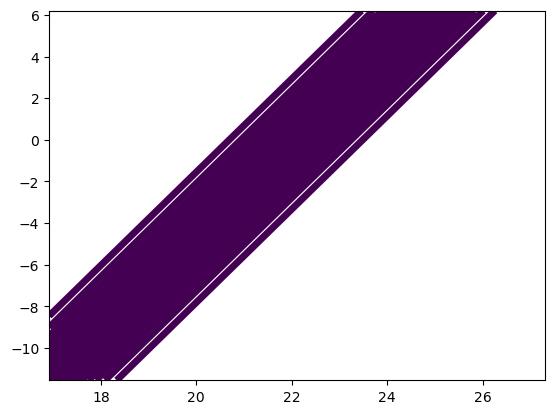

In [6]:
### vary contour percentage --> calculate completeness, purity, and blending fraction etc

contour_percnts = np.arange(10, 94, 4) / 100

# calculate sources in each redshift bin
z_bins = []
for z in range(6):
    # z_bins.append(redshift_cuts(sig_z, z)) # a stack of boolean arrays
    z_bins.append(redshift_cuts_cum(sig_z, z)) # cumulative redshift bins


# combination of a color-mag cut and a constant magnitude cut.
# the constant magnitude cut 22.2 here is derived from the W1 flux sensitivity in the COSMOS field;
# it varies between places, so I suggest using the previous z=22.5 to be safe if crowding is not too bad.
cut_const_zmag = 22.2

# recall ~ completeness
Recall = np.zeros(shape=(len(contour_percnts), len(z_bins)))
# precision ~ purity
Precision = np.zeros(shape=(len(contour_percnts), len(z_bins)))
# total number of sources that pass the selection cut given a contour boundary
Nsrc_selected = []
# combining all redshift bins, calculate the recall
cut = 0.2
Recall_allbins = [] 

# distance calculation
N_1pix_sep = [] # < 1 spherex pixel separation from nearest neighbors
N_halfpix = [] # < half spherex pixel separation (3.1'')
N_1subpix = [] # < 1/5 spherex pixel separation (1.24'')
N_2subpix = [] # < 2/5 spherex pixel separation (2.48'')

# fitting parameters for the boundaries
Fit = []

for i, percnt in enumerate(contour_percnts):
    
    # for each contour level, 
    # print("\nContour percentage = ", percnt)
    
    # fit the boundary
    contours = plt.contour(xx, yy, probs, levels=[percnt], linewidths=5)
    fit = calc_fit_contour(contours)
    Fit.append(fit)

    # apply the selection cut: left hand side: z-w1, right hand side: a*z_mag + b
    lhs = sphx_z_mag - sphx_w1_mag
    rhs = boundary_LS(sphx_z_mag, fit[0], fit[1])
    cut_clmag = (lhs>=rhs) | (sphx_z_mag<cut_const_zmag)
    
    # predicted good sources (that pass the selection cut)
    pred_good = tab_xmatch[cut_clmag]
    Nsrc_selected.append(len(pred_good))
    
    ## distance calculation: 
    RA = np.array(tab_xmatch['ra'][cut_clmag])
    DEC = np.array(tab_xmatch['dec'][cut_clmag])
    nearest_distances = calc_source_separation(RA, DEC)
    
    N_1pix_sep.append(len(np.where(nearest_distances <= 6.2)[0]))
    N_halfpix.append(len(np.where(nearest_distances <= 3.1)[0]))
    N_1subpix.append(len(np.where(nearest_distances <= 1.24)[0]))
    N_2subpix.append(len(np.where(nearest_distances <= 2.48)[0]))
    
    ## calculate total recall
    true_good = np.where(np.isin(tab_xmatch['Tractor_ID'][sig_z<cut], pred_good['Tractor_ID']))[0]
    Recall_allbins.append( len(true_good) / len(tab_xmatch[sig_z<cut]) )
    print(Recall_allbins[i])
    
    # for every redshift bin:  
    for z in range(len(z_bins)):
        # print(f"    redshift bin {z}")
        
        # predicted srcs in the given bin
        cut_clmag_zbin = cut_clmag & z_bins[z] 

        # predicted sources that are actually good sources in the given bin
        true_good = np.where(np.isin(tab_xmatch['Tractor_ID'][z_bins[z]], pred_good['Tractor_ID']))[0]

        # see the screenshot below, actual positives in the given bin
        actual_pos = tab_xmatch[z_bins[z]]

        # see the chart below...
        TP = len(true_good)
        FN = len(actual_pos) - TP

        recall = TP / len(actual_pos) 
        Recall[i, z] = recall

        precision = TP / len(pred_good)
        Precision[i, z] = precision



* For more context of like true positives, actual positives, etc..., here's a table summarizing the terms being used here. 

    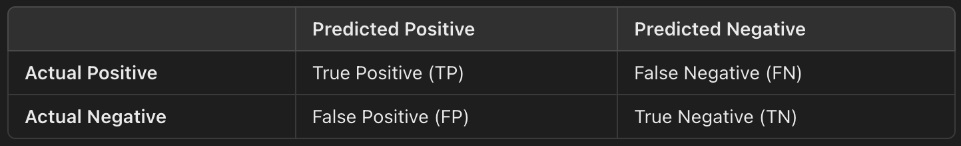

    Accuracy = $\frac{TP+TN}{TP+TN+FP+FN}$

    Precision = $\frac{TP}{TP+FP}$ = Purity

    Recall = $\frac{TP}{TP+FN}$ = Completeness

* Redshift bin definition:

    * Cumulatively:
        0. $\hat{\sigma}_z/(1+\hat{z}) < 0.003$
        1. $\hat{\sigma}_z/(1+\hat{z}) < 0.01$
        2. $\hat{\sigma}_z/(1+\hat{z}) < 0.03$
        3. $\hat{\sigma}_z/(1+\hat{z}) < 0.1$
        4. $\hat{\sigma}_z/(1+\hat{z}) < 0.2$

    * Individually:
        0. $\hat{\sigma}_z/(1+\hat{z}) < 0.003$
        1. $0.003\leq\hat{\sigma}_z/(1+\hat{z}) < 0.01$
        2. $0.01\leq\hat{\sigma}_z/(1+\hat{z}) < 0.03$
        3. $0.03\leq\hat{\sigma}_z/(1+\hat{z}) < 0.1$
        4. $0.1\leq\hat{\sigma}_z/(1+\hat{z}) < 0.2$

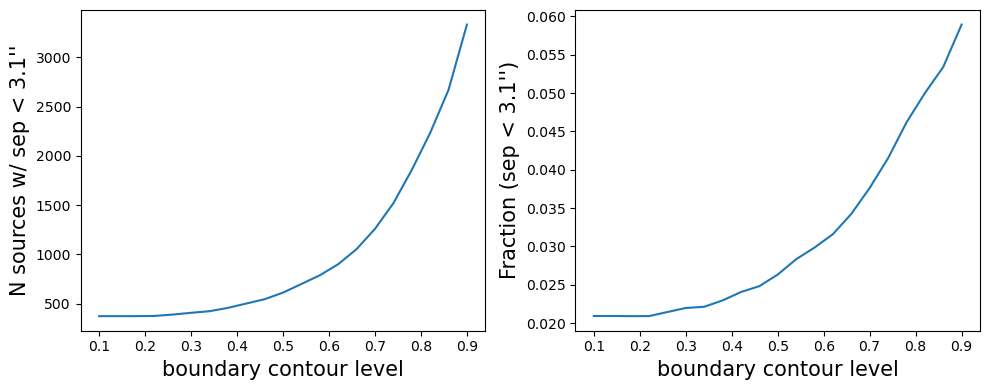

In [7]:
## source separation
N_1pix_sep = np.array(N_1pix_sep)
Nsrc_selected = np.array(Nsrc_selected)

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.xlabel("boundary contour level", fontsize=15)
plt.ylabel("N sources w/ sep < 3.1''", fontsize=15)
plt.plot(contour_percnts, N_halfpix)

plt.subplot(1,2,2)
plt.xlabel("boundary contour level", fontsize=15)
plt.ylabel("Fraction (sep < 3.1'')", fontsize=15)
plt.plot(contour_percnts, N_halfpix / Nsrc_selected)
fig.tight_layout()


1. want to have higher Recall, meaning we successfully predict more 'good' sources
2. want to have higher Precision, meaning we have less false positives, and more true positives


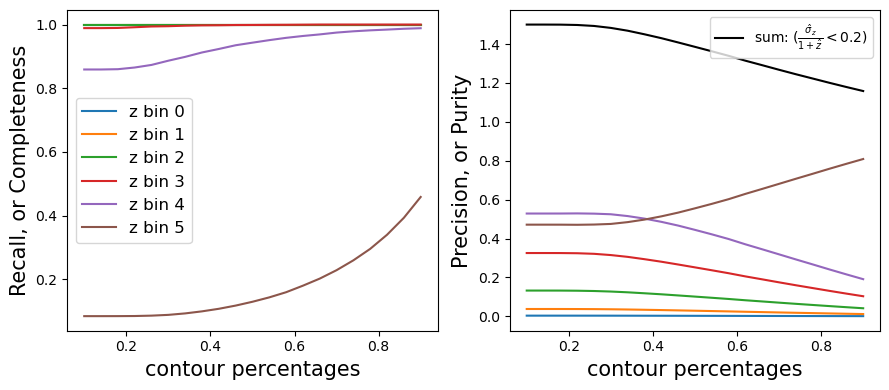

In [8]:
## plot completeness and recall
## Caution: the last bin (z bin 5 in the legend) is the non-science sample, sigma_z/1+z > 0.2

fig = plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
for z in range(Recall.shape[1]):
    plt.plot(contour_percnts[:], Recall[:,z], label=f'z bin {z}')
    
plt.ylabel("Recall, or Completeness", fontsize=15)
plt.xlabel("contour percentages", fontsize=15)
plt.legend(fontsize=12)

plt.subplot(1,2,2)
for z in range(Recall.shape[1]):
    plt.plot(contour_percnts[:], Precision[:,z])

plt.plot(contour_percnts[:], np.sum(Precision, axis=1), color='black', label=r'sum: ($\frac{\hat{\sigma}_z}{1+\hat{z}}<0.2$)')
plt.xlabel("contour percentages", fontsize=15)
plt.ylabel("Precision, or Purity", fontsize=15)
plt.legend(loc='upper right')
fig.tight_layout()

print("1. want to have higher Recall, meaning we successfully predict more 'good' sources")
print("2. want to have higher Precision, meaning we have less false positives, and more true positives")

__Final Cuts with Varying Contour Levels + Constant z-mag__:

$y \geq ax+b$ where $x$ is z-magnitude, and $y$ is z-w1 color; or

$x \leq 22.2$ where $x$ is z-magnitude

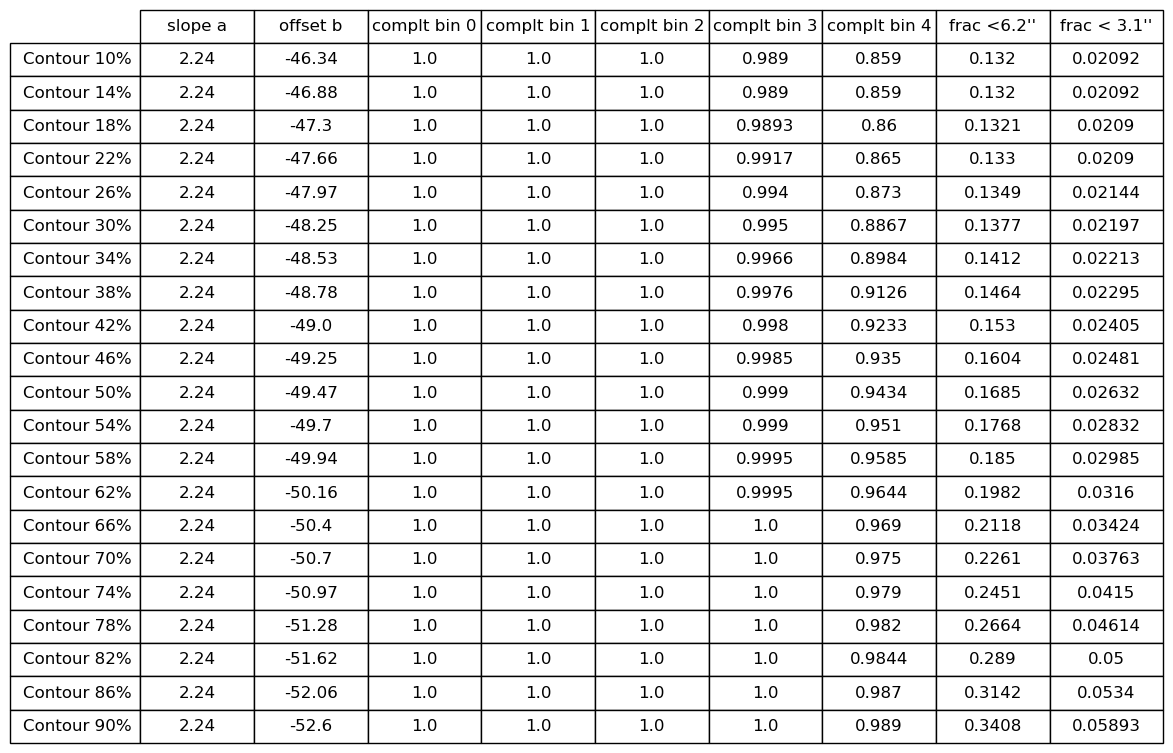

Caution, the result shown below also has a constant z-mag = 22.2 cut


In [9]:
# Example 2D data (can be your own data array)

data = np.hstack([np.array(Fit), Recall[:,:5]], dtype='float16')
sep = np.array([N_1pix_sep / Nsrc_selected, N_halfpix / Nsrc_selected])
data = np.hstack([data, sep.T], dtype='float16')

# Optional: Column and row labels
zbin_name = [f"complt bin {b}" for b in range(5)]
fit_name = ["slope a", "offset b"]
blending_name = ["frac <6.2''", "frac < 3.1''"]
column_labels = np.append(np.append(fit_name, zbin_name), blending_name)
row_labels = [f"Contour {(c*100):.0f}%" for c in contour_percnts]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12,6))

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Create a table
table = ax.table(
    cellText=data,
    rowLabels=row_labels,
    colLabels=column_labels,
    loc='center',
    cellLoc='center'  # Align cell text in the center
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.1, 2)

plt.show()

print("Caution, the result shown below also has a constant z-mag = 22.2 cut")